TP 5 - Rendu


# Localisation et détection d'objet

Dans ce TP, nous allons mettre en pratique certaines des méthodes présentées en cours pour localiser des objets dans une image.

En localisation et détection, on cherche à déterminer la position d'un objet, ainsi que sa classe, sous la forme d'une boîte englobante de largeur $b_w$ et hauteur $b_h$, et dont le centre a pour coordonnées le point $(b_x, b_y)$. 

<center> <img src="https://drive.google.com/uc?id=1_jHHv6ZDe-3Xz25jIZ6o177laBEfmMRR" style="width:500;height:300px;"></center>
<caption><center> Figure 1: Modèle de boîte englobante utilisé pour la localisation </center></caption>

Le problème de localisation considère qu'un seul objet est présent sur l'image, alors que le problème de détection cherche à déterminer l'ensemble des objets présents sur l'image.



Pour commencer, récupérez les images de la base de données :


In [ ]:
!git clone https://github.com/axelcarlier/wildlife.git

Cloning into 'wildlife'...
remote: Enumerating objects: 2973, done.
remote: Total 2973 (delta 0), reused 0 (delta 0), pack-reused 2973
Receiving objects: 100% (2973/2973), 433.18 MiB | 45.86 MiB/s, done.
Checking out files: 100% (3008/3008), done.


La base de données comporte 4 classes, pour les 4 animaux suivants : buffle, éléphant, rhinocéros et zèbre.

<center> <img src="https://drive.google.com/uc?id=1sej2InBiQDEmpk2RA7S2dLRsJvF_UszE" width=200>
<img src="https://drive.google.com/uc?id=1K8cO4plzVIXO1MC4mkRcFIFjgspHtOIm" width=200>
<img src="https://drive.google.com/uc?id=15pkHpPW_VR1joOyPryS1pavOTqmoNR88" width=200>
<img src="https://drive.google.com/uc?id=19zHZn-A_j8Sx0G3V2SwR_YNKF0dGI1NA" width=200></center>
<caption><center> Figure 2: Exemples d'images de la base de données </center></caption>

# Localisation et classification d'objet

Dans cette partie, nous allons nous concentrer sur le problème de la localisation d'un seul objet par classe. Pour le cas où il y aurait plusieurs objets sur la même image, nous considérerons uniquement l'objet dont la boîte englobante occupe la plus grande surface sur l'image.



## Préparation des données

La fonction ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.

In [ ]:
import PIL
from PIL import Image
import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.utils import np_utils

# La base de données contient 376 images de chacune des 4 classes
DATASET_SIZE = 376*4
# Nous choisissons ici la dimension dans laquelle nous allons redimensionner les images
# 64x64 est une dimension assez faible mais qui nous permettra d'avoir des expériences plus rapides
# 128x128 ou 256x256 permettraient d'avoir de meilleurs résultats mais au prix de plusieurs heures d'entraînement
IMAGE_SIZE = 64

def load_data_localization(image_size):
  # Chemin vers la base de données
  ds_path = "/content/wildlife/"
  # Chemins vers les données des 4 différentes classes
  paths = [ds_path + "buffalo/", ds_path + "elephant/", ds_path + "rhino/", ds_path + "zebra/"]
  # Indice d'ajout de données dans les variables x et y 
  i = 0
  # Préparation des structures de données pour x et y
  x = np.zeros((DATASET_SIZE, image_size, image_size, 3))
  y = np.empty((DATASET_SIZE, 9)) # 9 = 1 + 4 + 4 : présence / boîte englobante / classes
    
  # Parcours des chemins de chacune des classes
  for path in paths:

    # Parcours des fichiers (classés) du répertoire
    dirs = os.listdir(path)
    dirs.sort()

    for item in dirs:

      if os.path.isfile(path + item):
        # Extraction de l'extension du fichier 
        extension =item.split(".")[1]

        if extension=="jpg" or extension=="JPG":
          # Image : on va remplir la variable x
          # Lecture de l'image
          img = Image.open(path + item)
          # Mise à l'échelle de l'image
          img = img.resize((image_size,image_size), Image.ANTIALIAS)
          # Remplissage de la variable x
          x[i] = np.asarray(img)

        elif extension=="txt":
          # Fichier Texte : coordonnées de boîtes englobantes pour remplir y
          labels = open(path + item, "r")
          # Récupération des lignes du fichier texte
          labels= labels.read().split('\n')
          # Si la dernière ligne est vide, la supprimer 
          if labels[-1]=="":
            del labels[-1]

          # Indice de la boîte englobante de surface maximale
          j_max = 0
          if len(labels) > 1:
            aire_max = 0 # Surface de la boîte englobante de surface maximale
            # Parcours des boîtes englobantes des objets présents sur l'image
            for j in range(len(labels)):
              # Calcul de l'aire de la boîte englobante courante
              aire = float(labels[j].split()[3]) * float(labels[j].split()[4])
              # Mise à jour de la boîte englobante de surface maximale, si nécessaire
              if aire > aire_max:
                aire_max = aire
                j_max = j    

          # Un objet est présent sur l'image (presence = 1)
          presence = np.array([1], dtype="i")
          # "One-hot vector" représentant les probabilités de classe
          classes = np_utils.to_categorical(labels[j_max].split()[0], num_classes=4)
          # Coordonnées de la boîte englobante de surface maximale
          coordonnees = np.array(labels[j_max].split()[1:], dtype="f")
          # Remplissage de la variable y
          y[i, 0] = presence
          y[i, 1:5] = coordonnees
          y[i, 5:] = classes

          i = i + 1
        else:
          print("extension trouvée : ", extension)

  return x, y

x,y = load_data_localization(IMAGE_SIZE)


Séparation des données en ensembles d'entraînement et de validation

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]

# Et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255

In [ ]:
# Tests
print("shape of x_train", np.shape(x_train))
print("shape of y_train", np.shape(y_train))
print("shape of x_val", np.shape(x_val))
print("shape of y_val", np.shape(y_val))

shape of x_train (1278, 64, 64, 3)
shape of y_train (1278, 9)
shape of x_val (226, 64, 64, 3)
shape of y_val (226, 9)


## Fonctions utiles

Calcul du coefficient de Jaccard (intersection sur union) entre boîtes englobantes réelles et prédites.

In [ ]:
def compute_iou(y_true, y_pred):
  ### "Dénormalisation" des coordonnées des boîtes englobantes
  pred_box_xy = y_pred[..., 0:2]* y_std[0:2] + y_mean[0:2]
  true_box_xy = y_true[..., 0:2]* y_std[0:2] + y_mean[0:2]

  ### "Dénormalisation" des largeur et hauteur des boîtes englobantes
  pred_box_wh = y_pred[..., 2:4] * y_std[2:4] + y_mean[2:4]
  true_box_wh = y_true[..., 2:4] * y_std[2:4] + y_mean[2:4]
  
  # Calcul des coordonnées minimales et maximales des boiptes englobantes réelles
  true_wh_half = true_box_wh / 2.
  true_mins    = true_box_xy - true_wh_half
  true_maxes   = true_box_xy + true_wh_half
  
  # Calcul des coordonnées minimales et maximales des boiptes englobantes prédites
  pred_wh_half = pred_box_wh / 2.
  pred_mins    = pred_box_xy - pred_wh_half
  pred_maxes   = pred_box_xy + pred_wh_half       
  
  # Détermination de l'intersection des boîtes englobantes
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
  
  # Aire des boîtes englobantes prédites et réelles
  true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
  pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

  # Aire de l'union des boîtes prédites et réelles
  union_areas = pred_areas + true_areas - intersect_areas

  iou_scores  = tf.truediv(intersect_areas, union_areas)
  return iou_scores

def iou():
  def iou_metrics(y_true, y_pred):
    return compute_iou(y_true, y_pred)
  iou_metrics.__name__= "IoU"
  return iou_metrics

Visualisation des données et labels

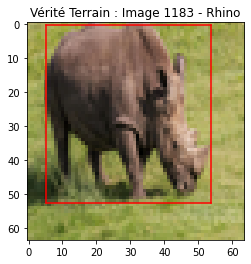

In [ ]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=IMAGE_SIZE):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "yellow", "red", "orange"] # Différentes couleurs pour les différentes classes
  classes = ["Buffalo", "Elephant", "Rhino", "Zebra"]

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))


  plt.show()

print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE)


In [ ]:
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

## Travail à faire



<center> <img src="https://drive.google.com/uc?id=1YzCZe4pgnjJDVGklAaCHZ7HhlPJsadg9" width=500></center>
<caption><center> Figure 3: Illustration de l'architecture du réseau à construire.  </center></caption>

Complétez les codes qui vous sont fournis pour obtenir un algorithme de localisation. 
Vous pouvez utiliser n'importe quelle base convolutive de votre choix, en revanche vous devrez porter une attention particulière à la couche de sortie.

Vous allez en fait produire 3 sorties différentes : une caractérisant la présence d'un objet, une autre fournissant les coordonnées de la boîte englobante, et enfin une dernière effectuant la classification.

In [ ]:
import keras
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential

def create_model_localisation(input_shape=(64, 64, 3)):

  input_layer = Input(shape=input_shape)


  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  # Couche 1
  x = conv1
  x = BatchNormalization(name='norm_1')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Couche 2
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Couche 3
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Couche 4
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Couche 5
  x = Conv2D((9), (1,1), strides=(1,1), padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)

  x = Flatten()(x)
    
  output_p = Dense(1, activation='sigmoid', name='p')(x)
  output_coord = Dense(4, activation='linear', name='coord')(x)
  output_class = Dense(4, activation='softmax', name='classes')(x)
  
  output= [output_p, output_coord, output_class]
  model = Model(input_layer, output)

  return model

<center> <img src="https://drive.google.com/uc?id=1bnh8zU7Os-w-5TT8hV4xDoThKQc-Ywc2" width=500></center>
<caption><center> Figure 4: Illustration des fonctions de coût à utiliser pour l'entraînement. </center></caption>

Pour entraîner votre réseau, vous allez donc devoir associer une fonction de coût à chacune des sorties du réseau. La fonction de coût totale sera la somme des trois fonctions de coût précédemment définies, pondérées par des poids définis dans la variable *loss_weights*.

**Prenez le temps de tester différentes valeurs de *loss_weights* en fonction de l'évolution des métriques que vous observerez pendant l'entraînement.**

Considérant que le plus important est de trouver la bonne classe ,on augmente le poid associé à la détection de la bonne classe

In [ ]:
from keras.optimizers import Adam

import tensorflow as tf



batch_size=16
model = create_model_localisation()
print("model shape", np.shape(model))
opt = Adam(learning_rate=3e-4)  

loss=[tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), tf.keras.losses.BinaryCrossentropy()]
metrics=[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 2]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )

model.summary()

history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:9]],
              epochs=30,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:9]]))



model shape ()
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           norm_1[0][0]                     
_______________________________________________________________________________

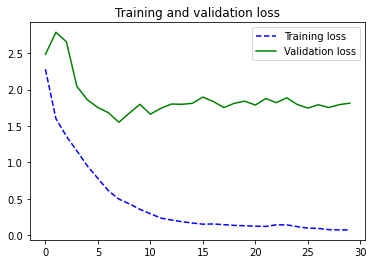

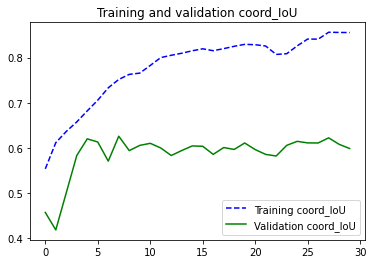

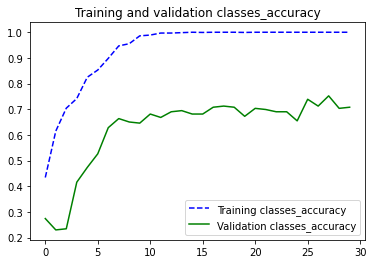

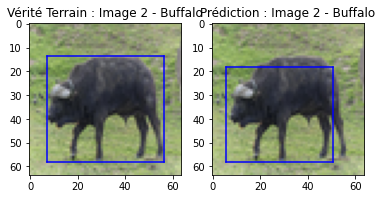

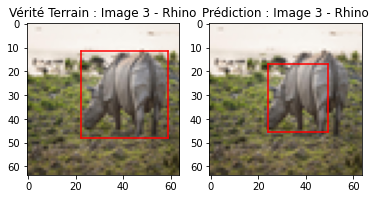

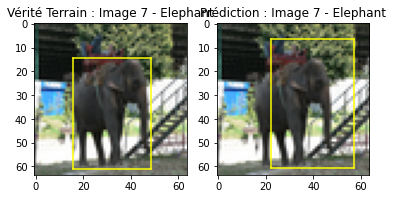

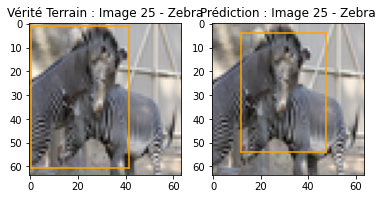

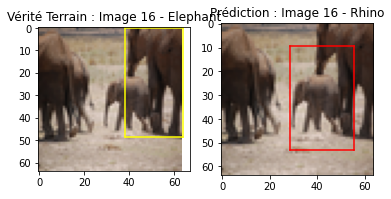

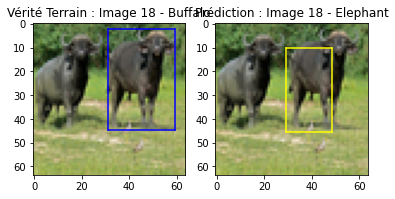

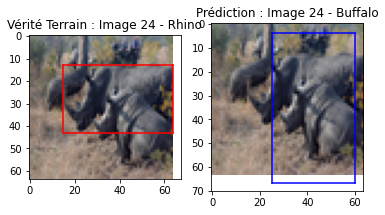

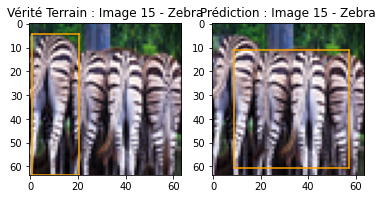

In [ ]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de l'accuracy des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de validation
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_val)
y_pred = np.zeros(y_val.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:9] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_val, y_val, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=25, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=16, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=18, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=24, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=15, image_size=IMAGE_SIZE)

**On constate qu'il y a du sur-apprentissage**

**Nous avons essayé de changer le poid sur les sorties. On remarque qu'augmenter le poid de la détection de classe augmente la class_accuracy**





En pratique, il est délicat de trouver une bonne combinaison des fonctions de perte tel que vous l'avez fait sur les cellules précédentes. L'entropie croisée et l'erreur quadratique moyenne donnent des valeurs trop différentes pour être combinables efficacement.

Une variante, mais qui tend à mieux fonctionner, est d'utiliser uniquement l'erreur quadratique moyenne comme perte pour toutes les sorties. 
Testez cette solution ci-dessous ; inutile de favoriser une perte par rapport à une autre ici, vous pouvez mettre le même poids pour toutes les pertes dans la variable *loss_weights*.

In [ ]:
from keras.optimizers import Adam

import tensorflow as tf

batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)  

loss = [tf.keras.losses.MeanSquaredError() ,tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()]
metrics =[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:9]],
              epochs=30,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:9]]))

Epoch 1/30
80/80 [==============================] - 15s 179ms/step - loss: 1.7857 - p_loss: 0.0167 - coord_loss: 1.5697 - classes_loss: 0.1993 - p_accuracy: 0.9739 - coord_IoU: 0.5198 - classes_accuracy: 0.3407 - val_loss: 1.3089 - val_p_loss: 9.2886e-05 - val_coord_loss: 1.0818 - val_classes_loss: 0.2270 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.5609 - val_classes_accuracy: 0.2301
Epoch 2/30
80/80 [==============================] - 14s 176ms/step - loss: 0.8557 - p_loss: 3.4708e-06 - coord_loss: 0.7180 - classes_loss: 0.1376 - p_accuracy: 1.0000 - coord_IoU: 0.6277 - classes_accuracy: 0.5869 - val_loss: 1.4708 - val_p_loss: 3.5710e-05 - val_coord_loss: 1.2432 - val_classes_loss: 0.2275 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.4938 - val_classes_accuracy: 0.3142
Epoch 3/30
80/80 [==============================] - 14s 176ms/step - loss: 0.6736 - p_loss: 1.5371e-06 - coord_loss: 0.5490 - classes_loss: 0.1246 - p_accuracy: 1.0000 - coord_IoU: 0.6533 - classes_accuracy: 0.6217 - val_l

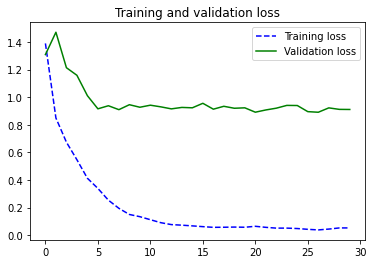

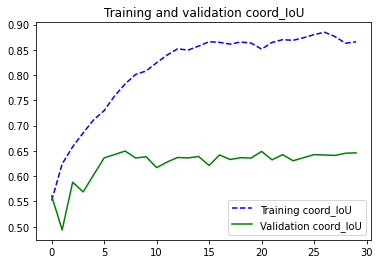

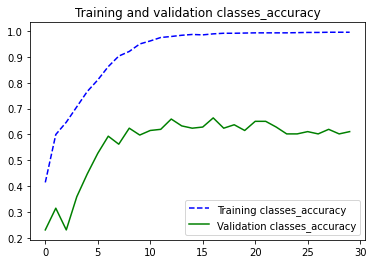

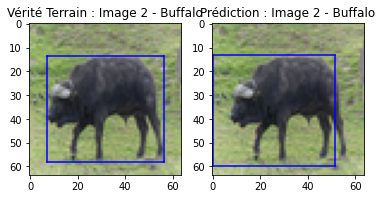

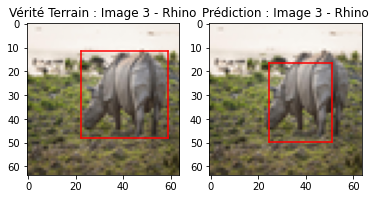

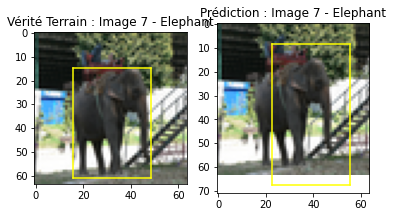

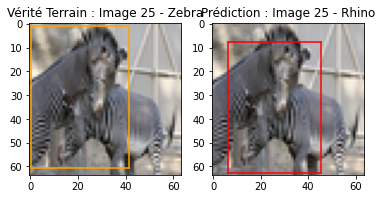

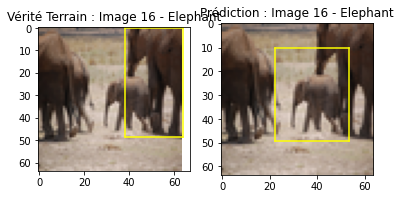

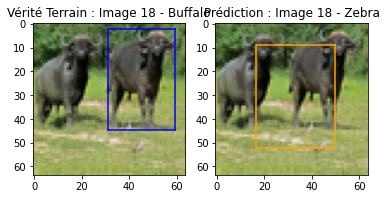

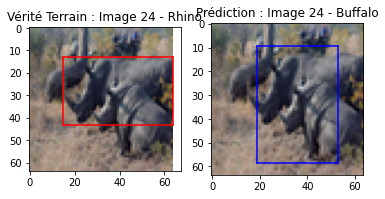

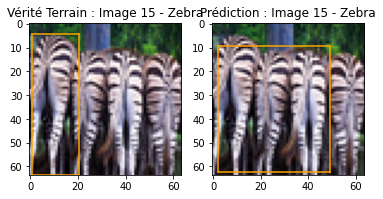

In [ ]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de l'accuracy des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de validation
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_val)
y_pred = np.zeros(y_val.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:9] = y_pred_classes[i]

print_data_localisation(x_val, y_val, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=25, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=16, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=18, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=24, image_size=IMAGE_SIZE)
print_data_localisation(x_val, y_val, y_pred = y_pred, id=15, image_size=IMAGE_SIZE)


**Changer le poid des classes modifie les accuracies, mais ne résoud pas le problème de sur-apprentisage**

Compte-tenu de la taille réduite de la base de données, les résultats ne sont pas mal du tout ! On observe quelques confusions entre certaines classes mais les prédictions sont souvent intéressantes.

Il devrait cependant subsister un fort surapprentissage à ce stade. Comme nous l'avons vu dans de précédents TPs, vous avez plusieurs possibilités qui s'offrent à vous pour le corriger : 


*   Régularisation par *weight decay* (utilisation de *kernel_regularizer* sur les couches de votre réseau)
*   Augmentation de la base de données. Vous pouvez pour cela vous appuyer sur l'exemple fourni en TP précédent, avec une classe *Sequence* et l'utilisation de la librairie *Albumentation*.
*   Utilisation de *transfer learning* : partant d'un réseau entraîné sur ImageNet (qui contient de nombreuses classes d'animaux), vous bénéficieriez de filtres très généraux qui aiderait à limiter le surapprentissage. 



# Détection d'objet : version simplifiée de YOLO

<center> <img src="https://drive.google.com/uc?id=1V4aAS7K_Akj83apuMZ2vRjNvjgdgoOCh" width=500></center>
<caption><center> Figure 5: Pipeline de l'algorithme YOLO ([Redmon 2016]) </center></caption>

Dans cette partie, nous allons tenter d'aller plus loin et d'implémenter une version simplifiée de YOLO. Cette version est considérée simplifiée car ne reprenant pas l'intégralité des éléments décrite dans l'article de Redmon (par exemple, sur le choix de l'optimiseur).

Pour rappel, l'idée de YOLO est de découper l'image en une grille de cellules et de réaliser une prédiction de plusieurs boîtes englobantes ainsi qu'une classification par cellule.

Dans la suite, et par souci de simplicité, nous ne considérerons qu'une boîte englobante par cellule.


## Préparation des données

In [ ]:
IMAGE_SIZE = 64
CELL_PER_DIM = 8
BOX_PER_CELL = 1
NB_CLASSES = 4
PIX_PER_CELL = IMAGE_SIZE/CELL_PER_DIM

DATASET_SIZE = 376*4


Chargement des données et mise en forme pour le problème de détection. Les données qui posent problème (plus d'une boîte englobante par cellule) sont indiquées et affichées pendant le chargement.

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/buffalo/273.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/buffalo/273.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/buffalo/273.txt


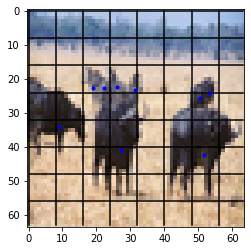

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/buffalo/300.txt


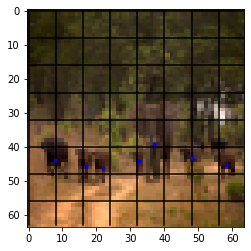

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/buffalo/339.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/buffalo/339.txt


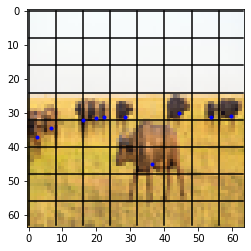

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/031.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/031.txt


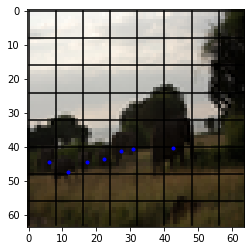

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/035.txt


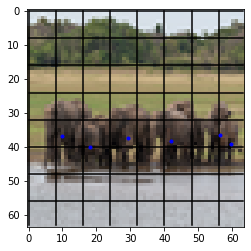

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/074.txt


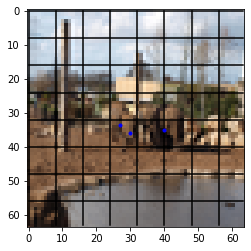

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/084.txt


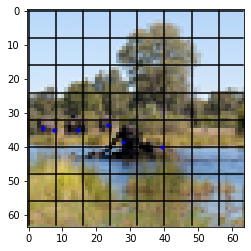

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/112.txt


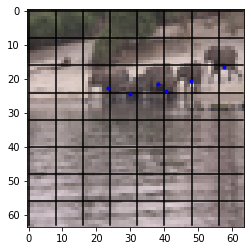

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/121.txt


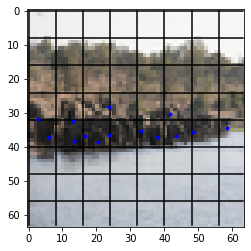

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/130.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/130.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/130.txt


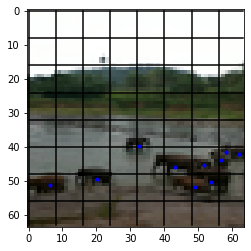

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/166.txt


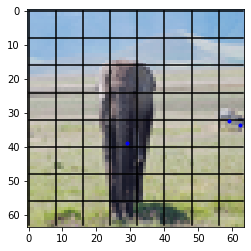

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/172.txt


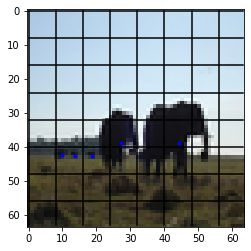

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/187.txt


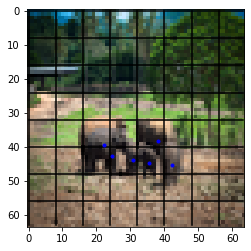

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/227.txt


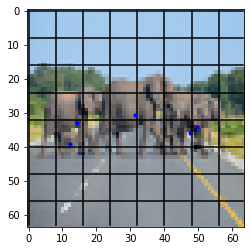

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/253.txt


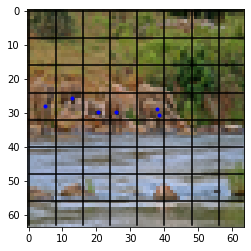

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/324.txt


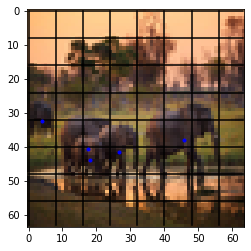

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/345.txt


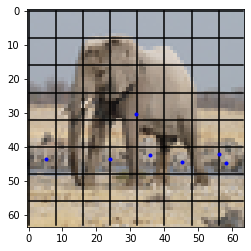

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/358.txt


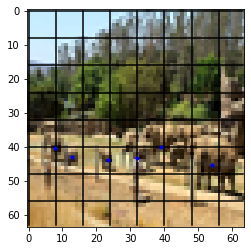

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/elephant/361.txt


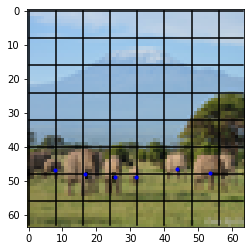

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/rhino/110.txt


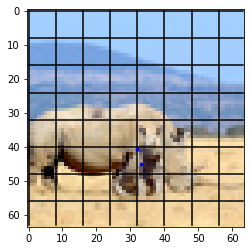

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/rhino/137.txt


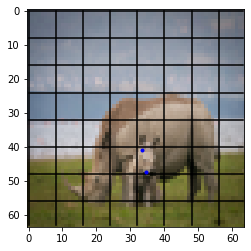

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/rhino/323.txt


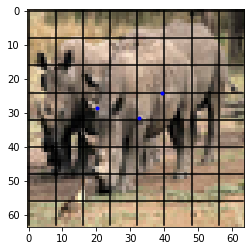

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/034.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/034.txt


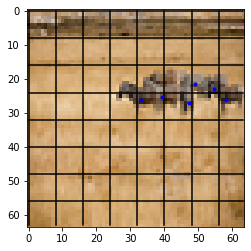

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/046.txt


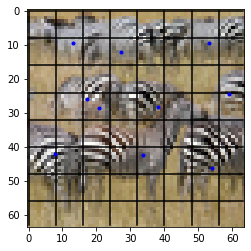

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/061.txt


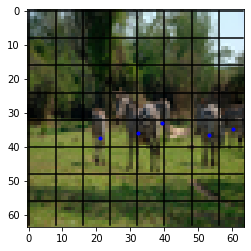

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/063.txt


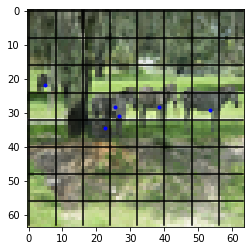

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/074.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/074.txt


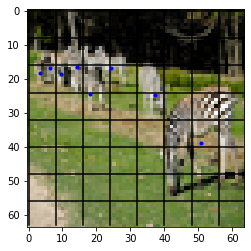

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/076.txt


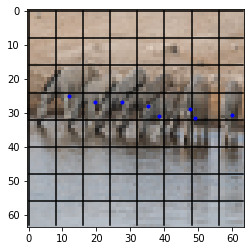

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/113.txt


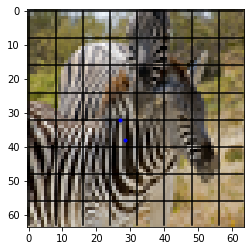

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/116.txt


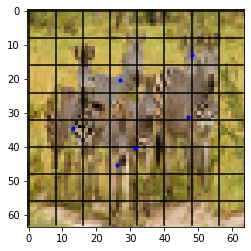

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt
ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/121.txt


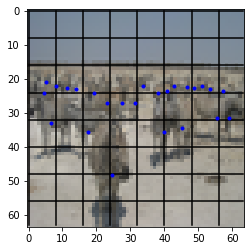

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/131.txt


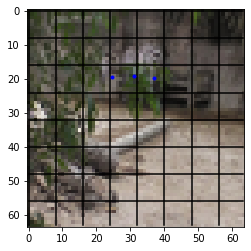

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/199.txt


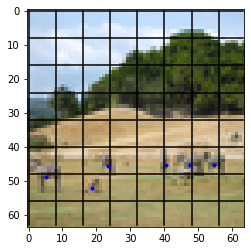

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/208.txt


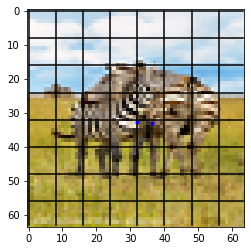

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/228.txt


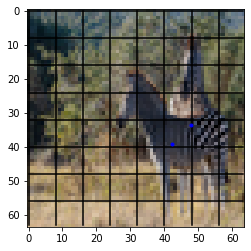

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/284.txt


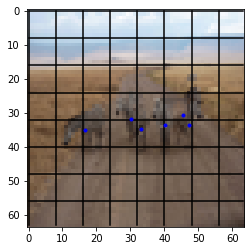

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/286.txt


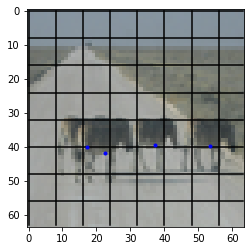

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/339.txt


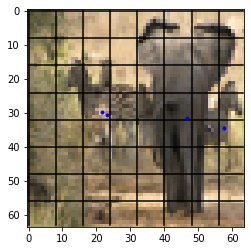

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/370.txt


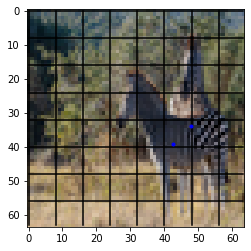

ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES
/content/wildlife/zebra/376.txt


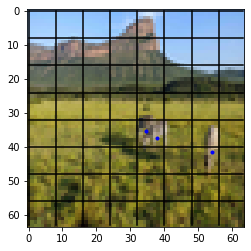

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

import PIL
from PIL import Image
import os, sys

import keras
from keras.utils import np_utils

def load_data_detection():
  # Chemin vers la base de données
  ds_path = "/content/wildlife/"
  # Chemins vers les données des 4 différentes classes
  paths = [ds_path+"buffalo/", ds_path+"elephant/", ds_path+"rhino/", ds_path+"zebra/"]
  # Indice d'ajout de données dans les variables x et y 
  i = 0
  # Préparation des structures de données pour x et y
  x = np.zeros((DATASET_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
  y = np.zeros((DATASET_SIZE, CELL_PER_DIM, CELL_PER_DIM, NB_CLASSES + 5*BOX_PER_CELL))

  # Parcours des chemins de chacune des classes
  for path in paths:

    # Parcours des fichiers (classés) du répertoire
    dirs = os.listdir(path)
    dirs.sort()

    for item in dirs:
      if os.path.isfile(path + item):
        # Extraction de l'extension du fichier 
        extension = item.split(".")[1]

        if extension=="jpg" or extension=="JPG":
          # Image : on va remplir la variable x
          # Lecture de l'image
          img = Image.open(path + item)
          #f, e = os.path.splitext(path+item)

          # Mise à l'échelle de l'image
          img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
          # Remplissage de la variable x
          x[i] = np.asarray(img, dtype=np.int32)

        elif extension=="txt":
          # Texte : coordonnées de boîtes englobantes pour remplir y
          labels = open(path + item, "r")
          # Récupération des lignes du fichier texte
          labels = labels.read().split('\n')
          # Si la dernière ligne est vide, la supprimer 
          if labels[-1]=="":
            del labels[-1]

          err_flag = 0
          boxes = []
          for label in labels:
            # Récupération des informations de la boîte englobante
            label = label.split()
            # Coordonnées du centre de la boîte englobante dans le repère image
            cx, cy = float(label[1]) * IMAGE_SIZE, float(label[2]) * IMAGE_SIZE
            # Détermination des indices de la cellule dans laquelle tombe le centre
            ind_x, ind_y = int(cx // PIX_PER_CELL), int(cy // PIX_PER_CELL)
            # YOLO : "The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell."
            # On va donc calculer les coordonnées du centre relativement à la cellule dans laquelle il se situe
            cx_cell = (cx - ind_x * PIX_PER_CELL) / PIX_PER_CELL
            cy_cell = (cy - ind_y * PIX_PER_CELL) / PIX_PER_CELL
            # Indice de confiance de la boîte englobante
            presence = np.array([1], dtype="i")
            # "One-hot vector" représentant les probabilités de classe dans la cellule
            classes = np_utils.to_categorical(label[0], num_classes=4)
            # On range les probabilités de classe à la fin du vecteur ([ BOX 1 ; BOX 2 ; ... ; BOX N ; CLASSES])
            y[i, ind_x, ind_y, 5 * BOX_PER_CELL:] = classes

            boxes.append([cx, cy, label[3]*IMAGE_SIZE, label[4]*IMAGE_SIZE])
            # Détermination de l'indice de la boîte englobante de cellule dans laquelle ranger les informations
            ind_box = 0
            while y[i, ind_x, ind_y, 5*ind_box] == 1 and ind_box < BOX_PER_CELL - 1:
              # Si la boîte d'indice courant est déjà utilisée (présence = 1) 
              # et que l'on a pas atteint le nombre maximal de boîtes, on passe à la boîte suivante
              ind_box = ind_box + 1

            if y[i, ind_x, ind_y, 5*ind_box] == 1:
              print("ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES")
              print(path + item)
              err_flag = 1
            else:
              y[i, ind_x, ind_y, 5*ind_box] = 1
              y[i, ind_x, ind_y, 5*ind_box + 1] = cx_cell
              y[i, ind_x, ind_y, 5*ind_box + 2] = cy_cell
              # Largeur et hauteur de boîte
              y[i, ind_x, ind_y, 5*ind_box + 3] = math.sqrt(float(label[3]))
              y[i, ind_x, ind_y, 5*ind_box + 4] = math.sqrt(float(label[4]))

          i = i + 1
          if err_flag == 1:
            img_name = item.split(".")[0]
            img = Image.open(path + img_name + '.jpg')
            # Mise à l'échelle de l'image
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)

            plt.imshow(img)
            for ind_cell in range(CELL_PER_DIM):                
              plt.plot([ind_cell*PIX_PER_CELL, ind_cell*PIX_PER_CELL], [0, IMAGE_SIZE-1], 'k-')
              plt.plot([0, IMAGE_SIZE-1], [ind_cell*PIX_PER_CELL, ind_cell*PIX_PER_CELL], 'k-')

            #for ind_y in range(CELL_PER_DIM):

            for ind_box_plot in range(len(boxes)):
              box = boxes[ind_box_plot]
              plt.plot(box[0], box[1], 'b.')
            plt.show()

        else:
          print("extension trouvée : ", extension)

  return x, y

x,y = load_data_detection()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Normalisation des images
x_train = x_train/255
x_val = x_val/255

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1278, 64, 64, 3), (1278, 8, 8, 9), (226, 64, 64, 3), (226, 8, 8, 9))

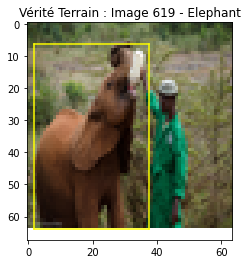

In [ ]:
def print_data_detection(x, y, id=None, image_size=IMAGE_SIZE):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "yellow", "red", "orange"] # Différentes couleurs pour les différentes classes
  classes = ["Buffalo", "Elephant", "Rhino", "Zebra"]

  boxes = lab[:, :, 1:5]
  for ind_x in range(CELL_PER_DIM):
    for ind_y in range(CELL_PER_DIM):
      box = boxes[ind_x, ind_y]
      box[0] = box[0] * PIX_PER_CELL + ind_x * PIX_PER_CELL
      box[1] = box[1] * PIX_PER_CELL + ind_y * PIX_PER_CELL
      box[2] = box[2]**2 * IMAGE_SIZE
      box[3] = box[3]**2 * IMAGE_SIZE
      boxes[ind_x, ind_y] = box

  # Récupération de toutes les informations des boîtes englobantes
  all_presences = np.reshape(lab[:, :, 0], (CELL_PER_DIM*CELL_PER_DIM))
  all_boxes = np.reshape(lab[:, :, 1:5], (-1, 4))
  all_classes = np.reshape(lab[:, :, 5:9], (-1, 4))

  # Eliminer toutes les boîtes englobantes dont la probabilité de presence est < 0.5 
  all_boxes = all_boxes[np.where(all_presences > 0.5)]
  all_classes = all_classes[np.where(all_presences > 0.5)]

  # Affichage de l'image
  plt.imshow(img)
  for i in range(all_boxes.shape[0]):

    # Détermination de la classe
    class_id = np.argmax(all_classes[i])
    lab = all_boxes[i]
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [lab[0]-lab[2]/2, lab[0]+lab[2]/2]
    p_y = [lab[1]-lab[3]/2, lab[1]+lab[3]/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))
  
  plt.show()  


print_data_detection(x_train, y_train, image_size=IMAGE_SIZE)



<center> <img src="https://drive.google.com/uc?id=1_wXc_gTIAr37STaxu3chq1EEjVSKv6a5" width=500></center>
<caption><center> Figure 6: Illustration de la couche de sortie de YOLO. </center></caption>

Le modèle que je vous propose ci-dessous n'est qu'une possibilité parmi beaucoup d'autres. L'article de Redmon mentionne une instabilité délicate pendant l'entraînement, ce qui m'a encouragé à choisir une fonction d'activation *elu* (*exponential linear unit*).

A vous de compléter la dernière couche pour avoir une sortie de la bonne dimension.

In [ ]:
import keras
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, Input
from keras.models import Sequential
from keras import regularizers

def create_model_YOLO(input_shape=(64, 64, 3)):

  input_layer = Input(shape=input_shape)

  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(input_layer)
  # drop = Dropout(0.1)(conv1)
  batchnorm = BatchNormalization()(conv1)

  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(batchnorm)
  # drop = Dropout(0.1)(conv1)
  batchnorm = BatchNormalization()(conv1)

  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(batchnorm)
  # drop = Dropout(0.1)(conv1)
  batchnorm = BatchNormalization()(conv1)

  pool1 = MaxPooling2D(pool_size=(2, 2))(batchnorm)
  
  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(pool1)
  # drop = Dropout(0.1)(conv2)
  batchnorm = BatchNormalization()(conv2)

  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(batchnorm)
  # drop = Dropout(0.1)(conv2)
  batchnorm = BatchNormalization()(conv2)

  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(batchnorm)
  # drop = Dropout(0.2)(conv2)
  batchnorm = BatchNormalization()(conv2)

  pool2 = MaxPooling2D(pool_size=(2, 2))(batchnorm)
  
  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(pool2)
  # drop = Dropout(0.1)(conv3)
  batchnorm = BatchNormalization()(conv3)

  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(batchnorm)
  # drop = Dropout(0.1)(conv3)
  batchnorm = BatchNormalization()(conv3)

  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l1_l2(l1=0, l2=2e-4))(batchnorm)
  # drop = Dropout(0.1)(conv3)
  batchnorm = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(batchnorm)

  dense4 = Flatten()(pool3)
  dense4 = Dense(512, kernel_regularizer=regularizers.l2(0.002), activation='elu')(dense4)
  dense5 = Dense(512, kernel_regularizer=regularizers.l2(0.002), activation='elu')(dense4)
  output = Dense(CELL_PER_DIM*CELL_PER_DIM*(NB_CLASSES+5*BOX_PER_CELL), activation='linear')(dense5)
  output = Reshape((CELL_PER_DIM, CELL_PER_DIM, NB_CLASSES+5*BOX_PER_CELL))(output)

  model = Model(input_layer, output)

  return model

In [ ]:
model.summary()
model = create_model_YOLO()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 64, 64, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 64, 64, 32)   0           norm_1[0][0]                     
____________________________________________________________________________________________

<center> <img src="https://drive.google.com/uc?id=1Fbt_Wh_BqZj8Pwt3-04325ItCkQp5G9X" style="width:500;height:300px;"></center>
<caption><center> Figure 7: Détail de la fonction de perte définie dans l'article YOLO v1 </center></caption>

Nous arrivons maintenant à la partie délicate de l'implémentation de YOLO : la définition de la fonction de coût à utiliser.

Lorsque l'on écrit une fonction de coût personnalisée en Keras, il est nécessaire d'utiliser uniquement les fonctions présentes sur la page suivante : 
https://www.tensorflow.org/api_docs/python/tf/keras/backend

En effet cette fonction de coût qui sera appelée pendant l'entraînement traitera des tenseurs, et non des tableau *numpy*. On doit donc utiliser la librairie Tensorflow qui permet de manipuler les tenseurs.

Une partie essentielle de la fonction est déjà écrite : celle qui permet de séparer les données des cellules dites "vide" (la vérité terrain ne contient pas de boîte englobante) des "non vides".

Le détail de la fonction de coût est indiqué ci-dessus : dans l'article $\lambda_{\text{coord}} = 5$ et $\lambda_{\text{noobj}} = 0.5$. Les $x_i$, $y_i$, $w_i$, $h_i$ correspondent aux coordonnées d'une boîte englobante, $C_i$ correspond à la probabilité de présence d'un objet dans la cellule, et les $p_i(c)$ sont les probabilités de classe.

A vous de compléter l'expression des sous-fonctions de la fonction de coût (les fonctions *K.sum* et *K.square* devraient vous suffire !)

**NB : cette implémentation de la fonction de coût est très simplifiée et prend en compte le fait qu'il n'y a qu'une seule boîte englobante par cellule.**

In [ ]:
from keras import backend as K

# Définition de la fonction de perte YOLO
def YOLOss(lambda_coord, lambda_noobj):

    # Partie "verte" : sous-partie concernant l'indice de confiance et les 
    # probabilités de classe dans le cas où une boîte est présente dans la cellule
    def box_loss(y_true, y_pred):
      square = K.square(y_true[:, 0] - y_pred[:, 0])
      sum = K.sum(square)

      square_2 = K.square(y_true[:, 5:] - y_pred[:, 5:])
      sum_2 = K.sum(square_2)

      return (sum + sum_2)

    # Partie "bleue" : sous-partie concernant les coordonnées de boîte englobante 
    # dans le cas où une boîte est présente dans la cellule
    def coord_loss(y_true, y_pred):
      square_x = K.square(y_true[:, 1] - y_pred[:, 1])
      square_y = K.square(y_true[:, 2] - y_pred[:, 2])
      sum_xy = K.sum(square_x + square_y)

      square_w = K.square( K.sqrt(y_true[:, 3]) - K.sqrt(y_pred[:, 3]) )
      square_h = K.square( K.sqrt(y_true[:, 4]) - K.sqrt(y_pred[:, 4]) )
      sum_wh = K.sum(square_w + square_h)

      return sum_wh + sum_xy


    # Partie "rouge" : sous-partie concernant l'indice de confiance  
    # dans le cas où aucune boîte n'est présente dans la cellule
    def nobox_loss(y_true, y_pred):
      return K.sum(K.square(y_true[:, 0] - y_pred[:, 0]))


    def YOLO_loss(y_true, y_pred):

      # On commence par reshape les tenseurs de bs x S x S x (5B+C) à (bsxSxS) x (5B+C)
      y_true = K.reshape(y_true, shape=(-1, 9))
      y_pred = K.reshape(y_pred, shape=(-1, 9))

      # On cherche (dans les labels y_true) les indices des cellules pour lesquelles au moins la première boîte englobante est présente
      not_empty = K.greater_equal(y_true[:, 0], 1)      
      indices = K.arange(0, K.shape(y_true)[0])
      indices_notempty_cells = indices[not_empty]

      empty = K.less_equal(y_true[:, 0], 0)
      indices_empty_cells = indices[empty]

      # On sépare les cellules de y_true et y_pred avec ou sans boîte englobante
      y_true_notempty = K.gather(y_true, indices_notempty_cells)
      y_pred_notempty = K.gather(y_pred, indices_notempty_cells)

      y_true_empty = K.gather(y_true, indices_empty_cells)
      y_pred_empty = K.gather(y_pred, indices_empty_cells)

      return box_loss(y_true_notempty, y_pred_notempty) + lambda_coord*coord_loss(y_true_notempty, y_pred_notempty) + lambda_noobj*nobox_loss(y_true_empty, y_pred_empty)

   
    # Return a function
    return YOLO_loss

In [ ]:
print("x train shape", np.shape(x_train))
print("y train shape", np.shape(y_train))

x train shape (1278, 64, 64, 3)
y train shape (1278, 8, 8, 9)


**On réalise une data augmentation avec imgaug**

In [ ]:
from imgaug import augmenters as iaa

x_train_augmented = x_train
y_train_augmented = y_train


seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.05)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.2))
    ),
], random_order=True) # apply augmenters in random order

nb_data = np.shape(x_train)[0]
for p in range(0, 3):
  print("data augmentation numéro : ", p)
  for i in range(0, nb_data):
    #print(i)
    image_aug = seq(images = x_train[i, ...])
    #print(np.shape())
    #print("image aug shape", np.shape(image_aug))
    #print("label shape", np.shape(y_train[i, ...]))
    #plt.imshow(image_aug)
    #print("image aug shape", np.shape(image_aug))
    #print("x train shape", np.shape(x_train))
    x_train_augmented = np.concatenate((x_train_augmented, np.array([image_aug])))
    y_train_augmented = np.concatenate((y_train_augmented, np.array([y_train[i,...]])))
  

data augmentation numéro :  0
data augmentation numéro :  1
data augmentation numéro :  2


x shape (5112, 64, 64, 3)


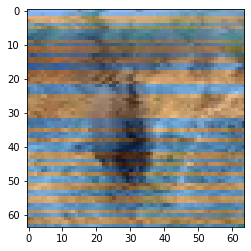

In [ ]:
print("x shape", np.shape(x_train_augmented))
plt.imshow(image_aug)

In [ ]:
from keras.optimizers import Adam

import tensorflow as tf

batch_size=16
model = create_model_YOLO()
opt = Adam(learning_rate=1e-4)  

loss=[YOLOss(5, 0.5)]

model.compile(loss=loss,
              optimizer=opt)

history = model.fit(x_train_augmented, y_train_augmented,
              epochs=300,
              batch_size=batch_size,           
              validation_data=(x_val, y_val))


Epoch 1/300
320/320 [==============================] - 7s 16ms/step - loss: 445.3732 - val_loss: 103.8044
Epoch 2/300
320/320 [==============================] - 4s 14ms/step - loss: 105.4702 - val_loss: 94.8871
Epoch 3/300
320/320 [==============================] - 5s 14ms/step - loss: 82.5773 - val_loss: 100.1815
Epoch 4/300
320/320 [==============================] - 5s 14ms/step - loss: 124.4387 - val_loss: 90.1390
Epoch 5/300
320/320 [==============================] - 5s 14ms/step - loss: 89.4046 - val_loss: 90.1748
Epoch 6/300
320/320 [==============================] - 4s 14ms/step - loss: 59.8623 - val_loss: 88.8366
Epoch 7/300
320/320 [==============================] - 5s 14ms/step - loss: 45.5908 - val_loss: 95.3899
Epoch 8/300
320/320 [==============================] - 5s 14ms/step - loss: 44.2772 - val_loss: 88.1422
Epoch 9/300
320/320 [==============================] - 5s 14ms/step - loss: 38.2140 - val_loss: 87.3829
Epoch 10/300
320/320 [==============================] - 5s 

In [ ]:
model.evaluate(x_train, y_train)

40/40 [==============================] - 0s 10ms/step - loss: 8.3052


8.305209159851074

In [ ]:
model.evaluate(x_train_augmented, y_train_augmented)

160/160 [==============================] - 1s 8ms/step - loss: 8.1392


8.139188766479492

In [ ]:
model.evaluate(x_val, y_val)

8/8 [==============================] - 0s 7ms/step - loss: 129.5187


129.5186767578125

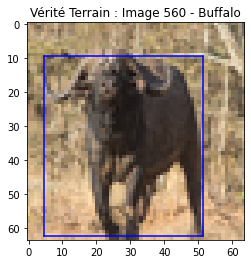

In [ ]:
y_pred = model.predict(x_train)
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE)


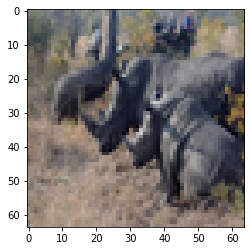

In [ ]:
y_val_pred = model.predict(x_val)
print_data_detection(x_val, y_val_pred, image_size=IMAGE_SIZE)

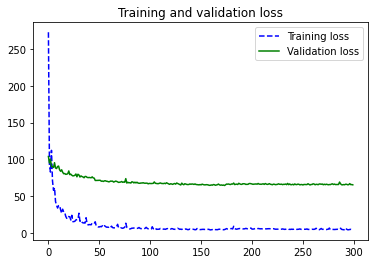

In [ ]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de l'accuracy des classes prédites
plot_training_analysis(history, metric='loss')


Bien que l'entraînement soit assez instable, vous devriez arriver à faire baisser la perte d'entrainement à des valeurs assez basses (< 10). A ce moment là, vous pouvez visualiser la prédiction du réseau sur l'ensemble d'entraînement et vous persuader que le réseau a appris quelque chose !

En revanche le sur-apprentissage est très important. A nouveau vous pouvez tester les techniques indiquées dans la première partie et essayer de limiter ce sur-apprentissage !

Pour améliorer les résultats, et réduire l'overfitting, nous avons


*   **Ajouté du Batchnorm (surtout pour rendre l'entraînement plus régulier)**
*   **Ajouté de la régularisation dans les couches**
*   **Ajouté de la data-augmentation avec imgaug**
*   **Nous avons tenté d'ajouter du dropout mais le résultat a été dramatique**


Val_loss finale : 65.


